In [4]:
# Data Manipulation and Handling
import polars as pl
import pandas as pd
import numpy as np
import psycopg2

# DB Credentials
from dotenv import load_dotenv
import os
import sys
from sqlalchemy import create_engine

# Machine Learning Libraries
import torch
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, chi2, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, accuracy_score, confusion_matrix, classification_report, roc_curve

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Lifecycle Management
import mlflow
import mlflow.sklearn

# Distributed Computing
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier

# Model Interpretability
import shap

# Hyperparameter Optimization
import optuna

# Automated Feature Engineering
import featuretools as ft

# Add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Custom Modules
from fetch_data_hook import fetch_sql_code, fetch_sql_file

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.


# ML Pipeline Flow

In [5]:
# 1. EDA Analysis
# 2. Feature Engineering
# 3. Train-Test Split
# 4. Feature Scaling: {normalization/standardization, dimension reduction techniques, handling imbalance datasets/sampling}
# 5. Model Training -> Tuning -> Evaluating
# 6. Model Prediction
# 7. Model Deployment

In [6]:
churn_df = fetch_sql_code('''
WITH temp1 AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp) AS rn,
        timestamp::date - ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp)::int AS streak_id
    FROM
        equity_value_data
),
temp2 AS (
    SELECT
        user_id,
        MIN(timestamp::date) AS start_streak_date,
        MAX(timestamp::date) AS end_streak_date,
        COUNT(*) AS duration_of_above10_streak
    FROM
        temp1
    GROUP BY
        user_id, streak_id
),
temp3 AS (
    SELECT
        *,
        LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS prev_above10_streak_date,
        start_streak_date - LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS duration_between_above10_streaks
    FROM
        temp2
)
SELECT distinct user_id
FROM temp3
WHERE duration_between_above10_streaks >= 28
''')
churn_df
churn_users = set(churn_df['user_id'].tolist())

df = fetch_sql_code('''
select * from features_data
''')

df['churn_flag'] = df['user_id'].apply(lambda x: 1 if x in churn_users else 0 )
df


,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn_flag
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0
...,...,...,...,...,...,...,...,...,...,...
5579,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,03880c726d8a4e5db006afe4119ad974,0
5580,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,ae8315109657f44852b24c6bca4decd6,1
5581,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,f29c174989f9737058fe808fcf264135,0
5582,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,24843497d1de88b2e7233f694436cb3a,0


In [7]:
'''
This pipeline includes the following:

Data Preprocessing: Label encoding, scaling, and feature engineering.
Handling Imbalance: Using SMOTE for oversampling the minority class.
Modeling and Hyperparameter Tuning: Using Optuna to tune the hyperparameters of models like XGBoost, LightGBM, RandomForest, and Logistic Regression.
Evaluation: Automatically selecting the best model with the highest AUC score.
Explainability: Using SHAP to interpret the model.

Key Updates compared to version2:
K-Fold Cross-Validation:

StratifiedKFold is used to split the data into 5 folds, preserving the class distribution. For each fold, the model is trained and evaluated on a different subset of data.
Precision-Recall AUC:

The Precision-Recall AUC is calculated using the probabilities from the model (y_pred_proba). This is especially helpful for evaluating models on imbalanced datasets.
ROC AUC and PR AUC:

For Optuna's objective, both ROC AUC and Precision-Recall AUC are calculated, and the average is returned. You could choose to optimize based on ROC AUC, PR AUC, or a combination of both (depending on your use case).


RECAP | differecne between version3 and version2:

Key Changes:
K-fold Cross-Validation:
Instead of a single train_test_split, I'll use Stratified K-Fold cross-validation to maintain the distribution of classes during each split. This is useful for imbalanced datasets.
Precision-Recall Curve:
We'll compute the Precision-Recall AUC in addition to ROC AUC to better evaluate model performance, especially with imbalanced classes.
'''

"\nThis pipeline includes the following:\n\nData Preprocessing: Label encoding, scaling, and feature engineering.\nHandling Imbalance: Using SMOTE for oversampling the minority class.\nModeling and Hyperparameter Tuning: Using Optuna to tune the hyperparameters of models like XGBoost, LightGBM, RandomForest, and Logistic Regression.\nEvaluation: Automatically selecting the best model with the highest AUC score.\nExplainability: Using SHAP to interpret the model.\n\nKey Updates compared to version2:\nK-Fold Cross-Validation:\n\nStratifiedKFold is used to split the data into 5 folds, preserving the class distribution. For each fold, the model is trained and evaluated on a different subset of data.\nPrecision-Recall AUC:\n\nThe Precision-Recall AUC is calculated using the probabilities from the model (y_pred_proba). This is especially helpful for evaluating models on imbalanced datasets.\nROC AUC and PR AUC:\n\nFor Optuna's objective, both ROC AUC and Precision-Recall AUC are calculated, 

### Step 1: Data Preprocessing and Feature Engineering

In [8]:
# Handle categorical columns: Label Encoding for ordinal and One-hot encoding for nominal
label_enc = LabelEncoder()
categorical_cols = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'platform', 'time_horizon']

# Label encoding for specific columns
for col in categorical_cols:
    df[col] = label_enc.fit_transform(df[col])

# One-hot encoding for non-ordinal categorical columns
df = pd.get_dummies(df, columns=['instrument_type_first_traded'], drop_first=True)

# Select numerical columns for scaling
numerical_cols = ['time_spent', 'first_deposit_amount']

# Scaling the numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Feature Engineering
df['deposit_per_time'] = df['first_deposit_amount'] / (df['time_spent'] + 1)
df['is_high_risk'] = (df['risk_tolerance'] == 0).astype(int)

# Drop columns that should not be used as features
X = df.drop(columns=['user_id', 'churn_flag'])

# Set target
y = df['churn_flag']

# Feature selection
selector = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=20)
X = selector.fit_transform(X, y)

# Handle imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


### Step 2: Model Definition and Objective Function for Optuna

In [9]:
# Cross-validation and model fitting inside the Optuna objective function
def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['xgboost', 'lightgbm', 'randomforest', 'logistic'])
    model = None

    if model_type == 'xgboost':
        model = xgb.XGBClassifier(
            max_depth=trial.suggest_int('max_depth', 3, 10),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            subsample=trial.suggest_float('subsample', 0.6, 1.0)
        )

    elif model_type == 'lightgbm':
        model = lgb.LGBMClassifier(
            num_leaves=trial.suggest_int('num_leaves', 20, 150),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            feature_fraction=trial.suggest_float('feature_fraction', 0.6, 1.0)
        )

    elif model_type == 'randomforest':
        model = RandomForestClassifier(
            max_depth=trial.suggest_int('max_depth', 3, 10),
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        )

    elif model_type == 'logistic':
        model = LogisticRegression(
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            C=trial.suggest_float('C', 0.01, 10, log=True),
            solver='liblinear'
        )

    # Cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = []
    pr_auc_scores = []

    for train_idx, test_idx in kfold.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx] # X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx] # y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Scoring
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        roc_auc_scores.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        pr_auc_scores.append(pr_auc)

    return np.mean(roc_auc_scores)

### Step 3: Running Optuna for Hyperparameter Tuning

In [10]:
# Run Optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=100) #n_trials=100)

# Print the best trial and parameters
print(f"Best Trial: {study.best_trial}")
print(f"Best Parameters: {study.best_params}")

[I 2024-10-03 21:39:24,878] A new study created in memory with name: no-name-5cd5254a-2f7a-4f50-aecf-4577f33f15d6


[LightGBM] [Warning] feature_fraction is set=0.7831878324924336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831878324924336
[LightGBM] [Warning] feature_fraction is set=0.7831878324924336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831878324924336
[LightGBM] [Info] Number of positive: 4244, number of negative: 4244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 8488, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] feature_fraction is set=0.7831878324924336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831878324924336
[LightGBM] [Warning] feature_fraction is

[I 2024-10-03 21:39:26,601] Trial 0 finished with value: 0.9189200521265926 and parameters: {'model_type': 'lightgbm', 'num_leaves': 50, 'learning_rate': 0.044848217932847156, 'n_estimators': 256, 'feature_fraction': 0.7831878324924336}. Best is trial 0 with value: 0.9189200521265926.


[LightGBM] [Warning] feature_fraction is set=0.7831878324924336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831878324924336


[I 2024-10-03 21:39:27,737] Trial 1 finished with value: 0.9068113680032619 and parameters: {'model_type': 'xgboost', 'max_depth': 10, 'learning_rate': 0.23400750828126507, 'n_estimators': 135, 'subsample': 0.7890483184420825}. Best is trial 0 with value: 0.9189200521265926.
[I 2024-10-03 21:39:27,812] Trial 2 finished with value: 0.6094647785730212 and parameters: {'model_type': 'logistic', 'penalty': 'l2', 'C': 1.6069893796657349}. Best is trial 0 with value: 0.9189200521265926.
[I 2024-10-03 21:39:38,823] Trial 3 finished with value: 0.8972653970211091 and parameters: {'model_type': 'randomforest', 'max_depth': 9, 'n_estimators': 198, 'max_features': 'log2'}. Best is trial 0 with value: 0.9189200521265926.
[I 2024-10-03 21:39:45,202] Trial 4 finished with value: 0.8967106414466816 and parameters: {'model_type': 'randomforest', 'max_depth': 9, 'n_estimators': 110, 'max_features': 'log2'}. Best is trial 0 with value: 0.9189200521265926.
[I 2024-10-03 21:39:52,766] Trial 5 finished wit

[LightGBM] [Warning] feature_fraction is set=0.9259057884558672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9259057884558672
[LightGBM] [Warning] feature_fraction is set=0.9259057884558672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9259057884558672
[LightGBM] [Info] Number of positive: 4244, number of negative: 4244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 8488, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] feature_fraction is set=0.9259057884558672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9259057884558672
[LightGBM] [Warning] feature_fraction is set=0.9259057884558672, colsample_bytree=1.0 will be ignored. C

[I 2024-10-03 21:39:55,025] Trial 6 finished with value: 0.9108770290329486 and parameters: {'model_type': 'lightgbm', 'num_leaves': 89, 'learning_rate': 0.011724491108495268, 'n_estimators': 167, 'feature_fraction': 0.9259057884558672}. Best is trial 0 with value: 0.9189200521265926.


[LightGBM] [Warning] feature_fraction is set=0.9259057884558672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9259057884558672


[W 2024-10-03 21:39:56,924] Trial 7 failed with parameters: {'model_type': 'randomforest', 'max_depth': 8, 'n_estimators': 240, 'max_features': 'log2'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\cheng\Workspace\robinhood_classifer\venv\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\cheng\AppData\Local\Temp\ipykernel_19676\2211351039.py", line 47, in objective
    model.fit(X_train, y_train)
  File "c:\Users\cheng\Workspace\robinhood_classifer\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\cheng\Workspace\robinhood_classifer\venv\lib\site-packages\sklearn\ensemble\_forest.py", line 456, in fit
    trees = Parallel(
  File "c:\Users\cheng\Workspace\robinhood_classifer\venv\lib\site-packages\sklearn\utils\parallel.py", line 65, in __call__
    return super().__call__(iterab

KeyboardInterrupt: 

### Step 4: Final Model Selection and Evaluation

In [11]:
'''
Purpose of train_test_split at the Final Step:
Hyperparameter tuning with Optuna is done on the resampled data during cross-validation (i.e., within the objective function), using the resampled training set to find the best parameters.

However, when you're evaluating the final model performance, you're aiming to test it on real-world data that hasn't been altered by resampling. This is where you use train_test_split on the original, non-resampled dataset (X_original and y_original), to ensure that your model is evaluated on data that reflects the true distribution (without artificial balancing).

Why This Is Correct by Design:
Training: You train your model on the resampled data because you want the model to learn from a balanced set of examples (which addresses class imbalance).

Testing/Evaluation: After the model is trained, you evaluate it on non-resampled data to see how well it generalizes to the original, imbalanced data. Using train_test_split here ensures that you're getting an unbiased performance estimate on the original distribution, which is critical because the final model will encounter this kind of data in production.

To Summarize:
Cross-validation on resampled data during tuning helps the model learn from balanced examples.
Final evaluation on non-resampled data with train_test_split helps you evaluate the model’s generalization ability on the original, imbalanced dataset.
So yes, the use of train_test_split in this case is by design and is part of standard practice to avoid data leakage while ensuring proper evaluation on real-world data.
'''
# After Optuna identifies the best model and parameters, we will retrain the model and evaluate it on the test set with detailed metrics.
# Train the final model based on best parameters
best_params = study.best_params
if best_params['model_type'] == 'xgboost':
    best_model = xgb.XGBClassifier(**best_params)
elif best_params['model_type'] == 'lightgbm':
    best_model = lgb.LGBMClassifier(**best_params)
elif best_params['model_type'] == 'randomforest':
    best_model = RandomForestClassifier(**best_params)
else:
    best_model = LogisticRegression(**best_params)

# Train on the full resampled data
best_model.fit(X_resampled, y_resampled)

# Use original dataset (non-resampled) for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.3, random_state=42)

# Predict on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate final model performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Final Model Accuracy: {accuracy}')
print(f'Final Model ROC AUC: {roc_auc}')
print(f'Final Model Precision-Recall AUC: {pr_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

[LightGBM] [Warning] Unknown parameter: model_type
[LightGBM] [Warning] feature_fraction is set=0.9751447021243461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751447021243461
[LightGBM] [Warning] Unknown parameter: model_type
[LightGBM] [Warning] feature_fraction is set=0.9751447021243461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751447021243461
[LightGBM] [Info] Number of positive: 5305, number of negative: 5305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 10610, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: model_type
[LightGBM] [Warning] feature_fraction i

### Step 5: Model Explainability with SHAP

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


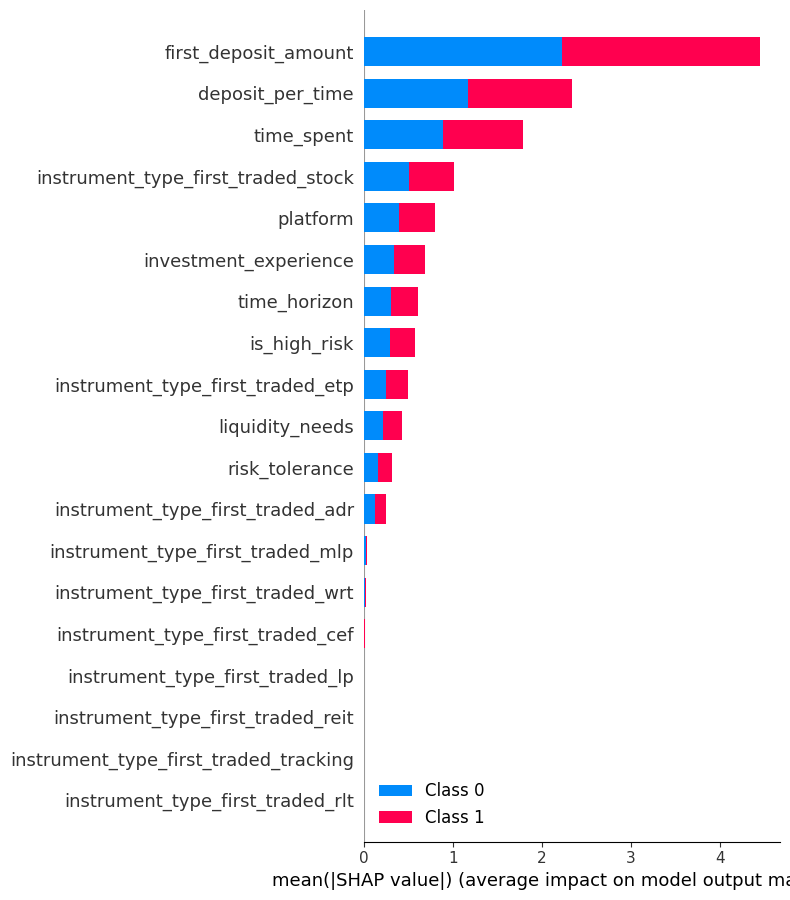

In [12]:
# SHAP for feature importance
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


### Step 6: Model Explainability with SHAP

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


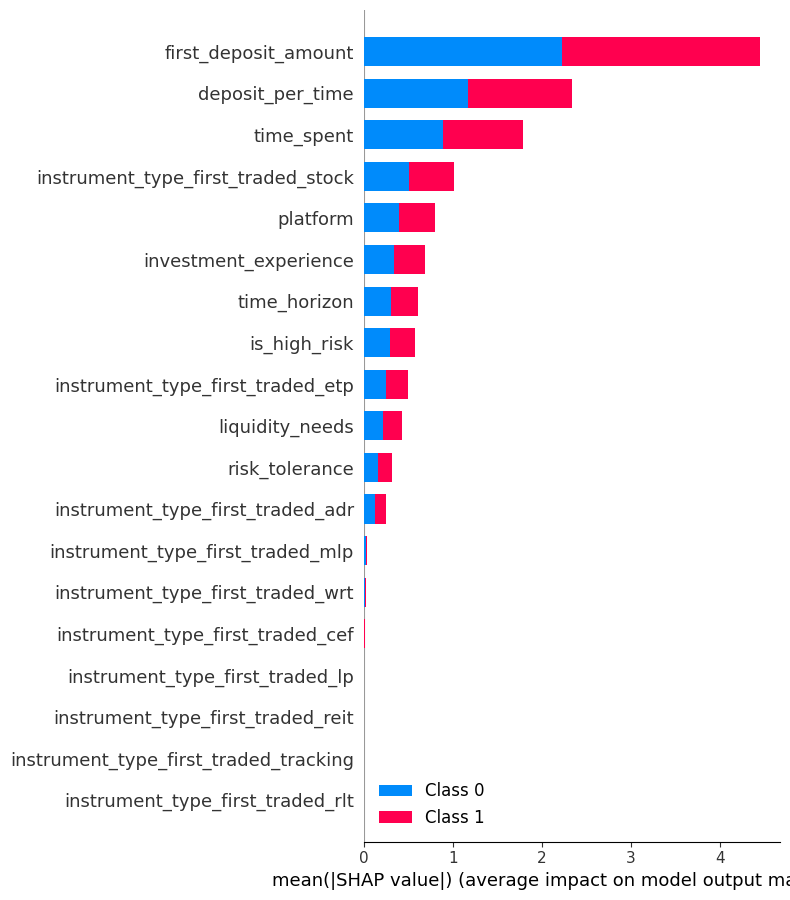

In [13]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)


## EDA

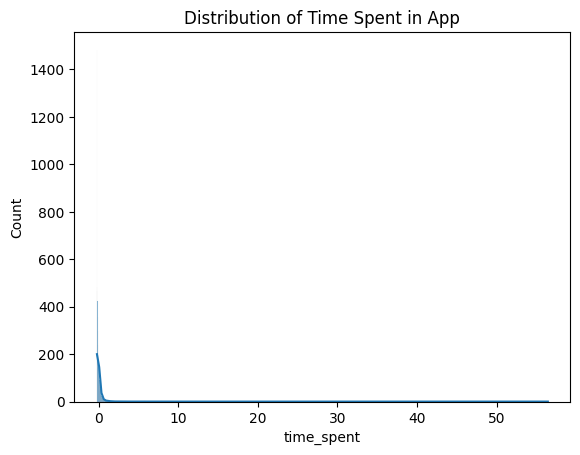

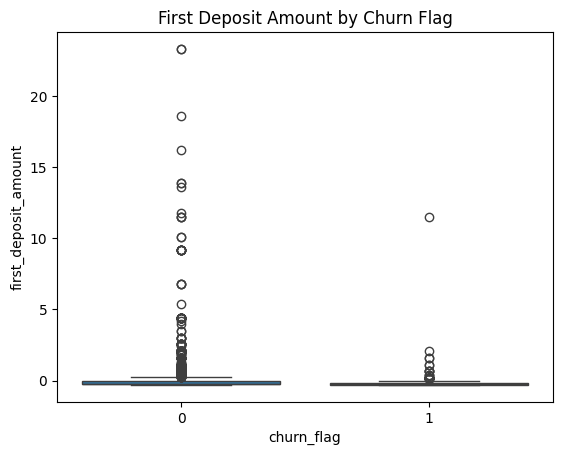

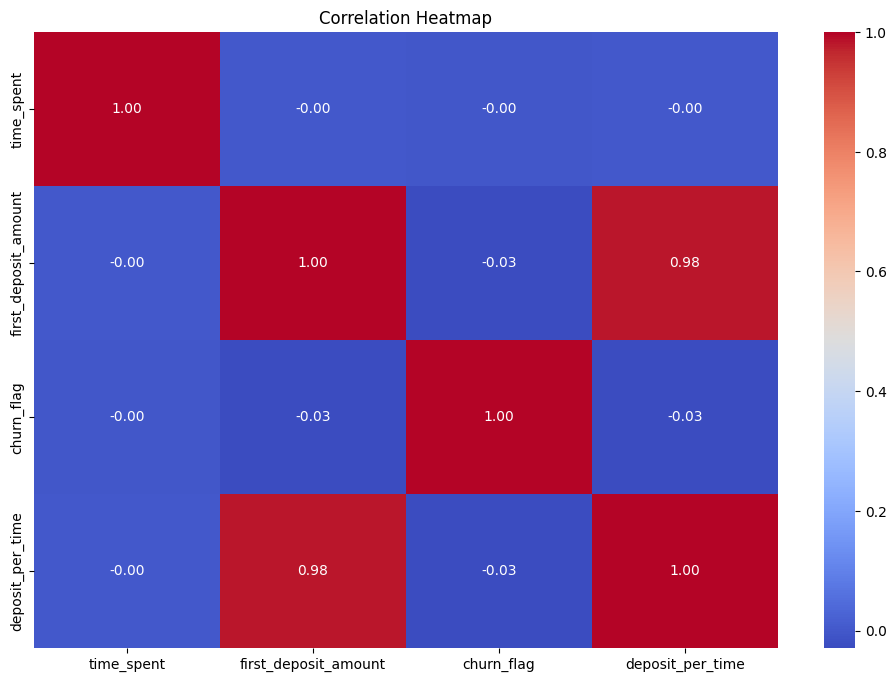

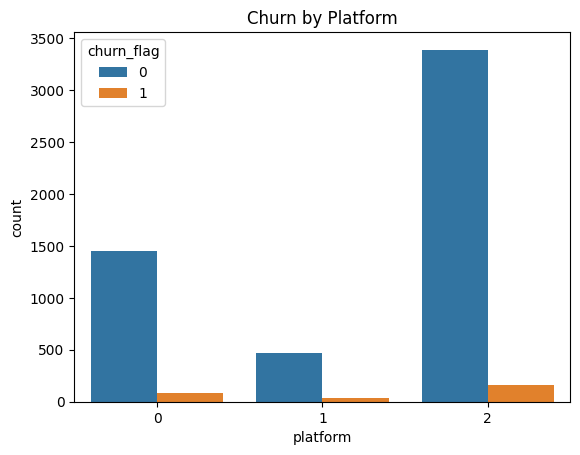

In [14]:
# Distribution of time spent in app
sns.histplot(df['time_spent'], kde=True)
plt.title('Distribution of Time Spent in App')
plt.show()

# Boxplot of first deposit amount by churn flag
sns.boxplot(x='churn_flag', y='first_deposit_amount', data=df)
plt.title('First Deposit Amount by Churn Flag')
plt.show()

# Select only the numerical columns from the DataFrame
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Create the heatmap using the correlation matrix of the numerical columns
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Countplot for churn by platform for categorical features
sns.countplot(x='platform', hue='churn_flag', data=df)
plt.title('Churn by Platform')
plt.show()


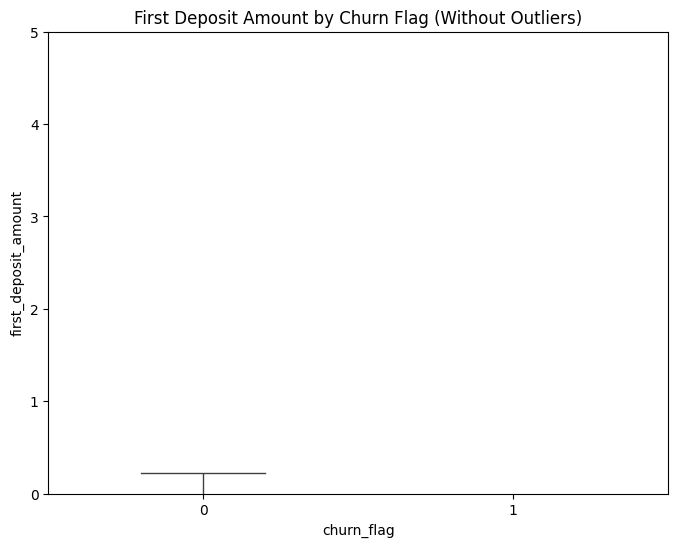

In [15]:
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.boxplot(x='churn_flag', y='first_deposit_amount', data=df, showfliers=False)
plt.ylim(0, 5)  # Set y-axis limits, adjust as necessary based on your data
plt.title('First Deposit Amount by Churn Flag (Without Outliers)')
plt.show()


In [16]:
'''
1. Advanced Resampling Techniques:
SMOTE Variants: Beyond traditional SMOTE, there are more advanced variants like SMOTE-NC (for categorical variables) or SMOTE-Tomek Links (combining oversampling with undersampling to remove noise).
ADASYN (Adaptive Synthetic Sampling): This method adapts SMOTE by focusing on more difficult-to-classify examples, potentially yielding better performance on harder cases in the minority class.
NearMiss: This is an undersampling method that selects negative examples near the decision boundary, making the classifier more sensitive to difficult minority examples.
2. Ensemble Learning:
Balanced Random Forests: Modify the random forest algorithm to draw balanced bootstrap samples (oversampling the minority class or undersampling the majority class at each tree).
EasyEnsemble and BalanceCascade: These are ensemble methods designed for imbalanced datasets. EasyEnsemble combines random undersampling with boosting to create a more robust model.
XGBoost with Imbalanced Data: XGBoost has built-in support for handling imbalanced data via the scale_pos_weight parameter. Setting it to the inverse ratio of class distribution helps the model learn the minority class better.
3. Class Weighting:
Instead of resampling, many models like XGBoost, LightGBM, RandomForest, and Logistic Regression support setting class weights to address class imbalance. By assigning higher weights to the minority class, you can penalize the model more for misclassifying minority samples.
Example: In XGBoost, use scale_pos_weight, and in RandomForestClassifier, use the class_weight='balanced' parameter.
4. Threshold Tuning:
The default decision threshold of 0.5 for classification models is often suboptimal for imbalanced datasets. Tuning the decision threshold can significantly improve performance, especially for metrics like precision, recall, and F1-score.
You can experiment with threshold-moving techniques to balance precision and recall better based on the model’s predicted probabilities.
5. Focal Loss:
Focal Loss is a modification of the cross-entropy loss that puts more focus on hard-to-classify examples, making it well-suited for imbalanced classification. This is widely used in deep learning models but can also be implemented in gradient boosting libraries.
Example: Focal Loss is supported in LightGBM and TensorFlow/Keras for imbalanced data.
6. Anomaly Detection Algorithms:
Since churn is often rare, you could treat it as an anomaly detection problem. Algorithms like Isolation Forest, One-Class SVM, or AutoEncoders can be repurposed for identifying rare events, such as churn, by flagging unusual behavior.
7. Stacking and Blending:
Stacking and Blending are ensemble techniques where multiple models are combined to improve performance. For imbalanced datasets, a combination of different classifiers (e.g., RandomForest, XGBoost, LightGBM) with different resampling techniques (SMOTE for some, class weighting for others) can produce better results.
You can also consider blending models that perform well on different metrics (e.g., one model optimized for precision, another for recall) to create a more robust classifier.
8. Feature Engineering Specific to Churn:
Behavioral Features: Focus on creating time-based features that capture user behavior over time. For example, features like time since last transaction, recency, frequency, and monetary value (RFM analysis) can be useful for identifying churn patterns.
Interaction Features: Combinations of existing features (e.g., deposit amount per time spent) can capture complex relationships that models may not easily detect.
Lag Features: Incorporate lag features or rolling windows to track user behavior over time (e.g., average time spent in the last 3 months, frequency of visits in the last 30 days).
9. Cost-Sensitive Learning:
In cost-sensitive learning, you explicitly define the cost of misclassification. For churn datasets, you can set a higher cost for misclassifying churners (false negatives) to emphasize reducing churn prediction errors.
You can implement custom loss functions or weight misclassification errors according to business impact (e.g., churn has a higher cost than non-churn).
10. Bayesian Optimization for Hyperparameter Tuning:
Optuna is great, but you can take hyperparameter tuning a step further with Bayesian Optimization. Libraries like Hyperopt and BayesianOptimization can help fine-tune hyperparameters in a more data-efficient manner, often converging faster and leading to better models.
11. Explainability Tools:
SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations): Use these tools to explain model predictions, especially for imbalanced data. These techniques can help identify why the model misclassifies minority class instances, leading to insights into feature engineering or model tuning.
12. Time-Series Modeling (if relevant):
If your churn data is time-dependent, consider using time-series classification models like Prophet, LSTM, or GRU. These models can capture temporal trends and patterns that might be critical for predicting churn.
13. Active Learning:
In cases where obtaining labeled data is expensive, active learning can be used to focus on annotating the most informative instances (e.g., uncertain predictions). This can help when labeled data for churn is sparse, improving model performance without needing massive amounts of data.
14. Custom Evaluation Metrics:
Use domain-specific metrics that reflect the business cost of churn (e.g., focus on high-recall models if missing a churner is more expensive). Additionally, consider profit-based metrics or a custom metric like a "churn score" that integrates recall and business costs.
Conclusion:
For a churn prediction task with imbalanced data, combining resampling techniques, ensemble learning, precision-recall optimization, class weighting, and advanced feature engineering is key. Incorporating modern methods like focal loss, Bayesian optimization, and explainability tools like SHAP can significantly boost model performance and interpretability.
'''

'\n1. Advanced Resampling Techniques:\nSMOTE Variants: Beyond traditional SMOTE, there are more advanced variants like SMOTE-NC (for categorical variables) or SMOTE-Tomek Links (combining oversampling with undersampling to remove noise).\nADASYN (Adaptive Synthetic Sampling): This method adapts SMOTE by focusing on more difficult-to-classify examples, potentially yielding better performance on harder cases in the minority class.\nNearMiss: This is an undersampling method that selects negative examples near the decision boundary, making the classifier more sensitive to difficult minority examples.\n2. Ensemble Learning:\nBalanced Random Forests: Modify the random forest algorithm to draw balanced bootstrap samples (oversampling the minority class or undersampling the majority class at each tree).\nEasyEnsemble and BalanceCascade: These are ensemble methods designed for imbalanced datasets. EasyEnsemble combines random undersampling with boosting to create a more robust model.\nXGBoost w